# Problema de transporte discreto - Destinos variables - Con término cuadrático

Dadas dos distribuciones de probabilidad discretas:

* $X$: con soporte $x_1<x_2<\ldots<x_m$ con probabilidades $P(X=x_i) = p_i$.
* $Y$: con soporte $y_1<y_2<\ldots<y_n$ con probabilidades $P(Y=y_j) = q_j$.

Queremos hallar una distribución conjunta $A=(a_{ij}) \geqslant 0$ tal que:

$$\min_{a_{ij}} \sum_{i,j} a_{ij} c_{ij} + \epsilon \sum_{j}\phi (q_{j})$$

sujeto a:

$$\sum_j a_{ij} = p_i \quad \forall i=1,\ldots,m,$$

$$\sum_i a_{ij} = q_j \leq m/(n-1)*\theta \quad \forall j=1,\ldots,(n-1) \,\,(VAR)$$ 

$$\sum_i a_{in} = q_n \quad .$$ 



## Caso 3: 
### Cargador lejano con capacidad infinita

$x_{i}, y_{j} \in R^{2}$

$c_{ij} = |x_{i} - y_{j}|$

$\phi(x) = \frac{x^{2}}{2}$

In [1]:
## Configuración inicial

# m = cantidad de vehículos
m = 100;
x = sortslices(rand(m,2), dims = 1);
p = 2*rand(m) # No son los autos, sino cantida de carga que necesitan (uniforme [0,2] -> media 1)

# n = cantidad de cargadores (totales)
n = 6;
y = sortslices(rand(n,2), dims = 1);
y = vcat(y, [2 0.5]) #Se agrega un cargador lejano
n=size(y)[1];

In [2]:
# l = factor limitanta de capacidad de cargadores
l = 0.5;

# k = cantidad de iteraciones de K-means
k = 5;

In [3]:
# Creación del modelo

using JuMP, GLPK, Ipopt
#revisar paquete distances.JL

#epsilon
eps =0.01 #200

#model = JuMP.Model(GLPK.Optimizer) #Algoritmo de programación lineal
model = JuMP.Model(Ipopt.Optimizer) #Algoritmo de punto interior

#Calculo los pesos Cij = |xi-yj| (distancia euclidea en R^2)
w1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^2
w2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^2
W=(w1+w2).^(1/2)

@variable(model,A[1:m,1:n]>=0)
@variable(model,q1[1:n-1]<=(m/(n-1)*l)) # carga máxima por auto con tolerancia
@variable(model,q2) #ultimo cargador sin límite

conp = @constraint(model, sum(A, dims=2).==p)
conq = @constraint(model, sum(A, dims=1).==vcat(q1,q2)')
#conq2 = @constraint(model, sum(A[:, n], dims=1).==q2')

@objective(model,Min, sum( A.*W ) + eps/2 * (vcat(q1,q2)'*vcat(q1,q2)) )
#@objective(model,Min, sum( A.*W ))

model

A JuMP Model
Minimization problem with:
Variables: 707
Objective function type: QuadExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 107 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 700 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 6 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: A, q1, q2

In [4]:
optimize!(model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1407
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        7

Total number of variables............................:      707
                     variables with only lower bounds:      700
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        6
Total number of equality constraints.................:      107
Total number of inequality co

In [5]:
objective_value(model)

112.92010887342123

In [6]:
#Extraigo el valor optimo
#value.(A)
round.(value.(A), digits=3)

100×7 Matrix{Float64}:
  0.0     0.255   0.0   0.0     0.0   0.0    0.0
  1.03    0.0     0.0  -0.0     0.0  -0.0    0.0
 -0.0     0.0     0.0   0.925  -0.0   0.0    0.0
  1.538   0.0     0.0  -0.0     0.0   0.0    0.0
 -0.0     0.749   0.0   0.0     0.0   1.083  0.0
 -0.0     0.399   0.0   0.0    -0.0   0.0    0.0
  0.0     0.46    0.0   0.0    -0.0   0.0    0.0
 -0.0     0.0     0.0   0.0     0.0   1.955  0.0
 -0.0     0.0     0.0   1.871  -0.0   0.0    0.0
 -0.0     1.475   0.0   0.0    -0.0   0.0    0.0
  0.0     0.649   0.0   0.0     0.0   0.0    0.0
 -0.0     0.0     0.0   0.0    -0.0   1.92   0.0
 -0.0     0.651   0.0   0.0    -0.0   0.0    0.0
  ⋮                                   ⋮      
 -0.0    -0.0    -0.0  -0.0     0.0  -0.0    0.172
 -0.0    -0.0    -0.0  -0.0    -0.0   0.0    1.107
 -0.0    -0.0    -0.0  -0.0     0.0  -0.0    0.829
 -0.0    -0.0    -0.0  -0.0    -0.0   0.0    1.556
 -0.0    -0.0    -0.0  -0.0    -0.0  -0.0    1.73
 -0.0    -0.0    -0.0  -0.0    -0.0  -0.

In [7]:
round.(value.(q1), digits=3)

6-element Vector{Float64}:
 8.333
 8.333
 8.333
 8.333
 8.333
 8.333

In [8]:
round.(value.(q2), digits=3)

54.785

In [9]:
#Extraigo los multiplicadores de p
lambda = dual.(conp);

In [10]:
#Redondea los valores de A para que sean 0 o 1 (Probar)
Ar = round.(value.(A));
Ao = value.(A);

#Separa los puntos por destino (buscando 1s)
#X = [x[findall(x->x==1, Ar[:,i]),1] for i in 1:n];
#Y = [x[findall(x->x==1, Ar[:,i]),2] for i in 1:n];

#Separa los puntos por destino (buscando maximos)
maximos = [argmax(Ao[i,:]) for i in 1:m];
X = [x[findall(x->x==i, maximos),1] for i in 1:n];
Y = [x[findall(x->x==i, maximos),2] for i in 1:n];

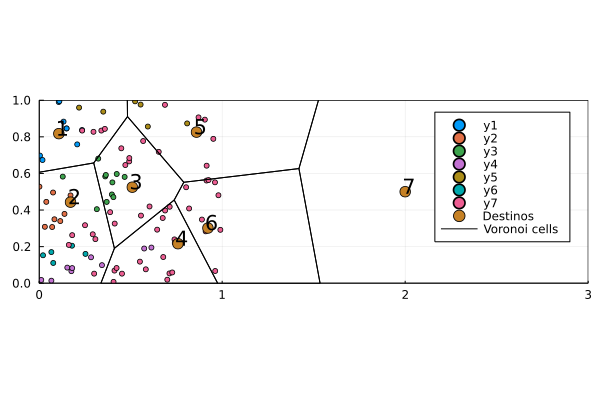

In [11]:
using VoronoiCells
using GeometryBasics
using Plots
using Random

gr()
Plots.GRBackend()

#crea la lista de destinos
points = [Point2(y[i,1], y[i,2]) for i in 1:n] 


#Conjuntos de Voronoi
rect = Rectangle(Point2(0, 0), Point2(3, 1))
tess = voronoicells(points, rect);

scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :topright) #Grafica los origenes, con color por destino
scatter!(y[:,1], y[:,2], markersize = 6, label = "Destinos") #Plotea los destinos
annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) #Agrega lo números en los destinos
plot!(tess, color = :black)